In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import sys
sys.path.append(r'\Users\Mochi\AppData\Local\Programs\Python\Python310\Lib\site-packages')
import quads
import numpy as np
import random

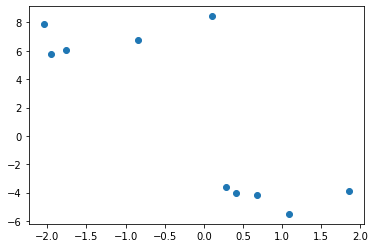

In [2]:
X, y = make_blobs(n_samples=10, centers=2, n_features=2,random_state=100)
plt.scatter(X[:,0], X[:,1])

In [3]:
class Node:
    def __init__(self, node_id, dataset):
        """
        dataset : np.array
        """
        self.node_id = node_id
        self.dataset = dataset
        self.points = dataset[:,:-1]
        self.clusters = dataset[:,-1]
        self.parent = None
        self.left = None
        self.right = None
    
    def __repr__(self):
        return 'Node {}: {}'.format(str(self.node_id), str(self.dataset))

       
    def add_left(self, left_children, current_id):
        left = Node(current_id+1, left_children)
        left.parent = self
        self.left = left
        
    def add_right(self, right_children, current_id):
        right = Node(current_id+2, right_children)
        right.parent = self
        self.right = right

In [4]:
class Fair_Split_Tree:
    """A node contained in a fair split tree.

    """

    def __init__(self, dataset, k):
        """
        dataset : np.array
        """
        self.dataset = dataset
        self.root = Node(0, dataset)
        self.nodes = []
        self.k = k
        
        self.nodes.append(self.root)
      
    def pick_random(self, dataset):
        same = True
        labels = dataset[:,-1]
        if (labels == labels[0]).all():
            while same:              
                points = np.array(random.choices(dataset, k=2))
                if not (points[0][:-1] == points[1][:-1]).all():
                    same = False
        else:
            while same:
                
                points = np.array(random.choices(dataset, k=2))
                if not (points[0][:-1] == points[1][:-1]).all() and not points[0][-1] == points[1][-1] :
                    same = False
        new_points = np.array([points[0][:-1],points[1][:-1]])
        return new_points
    def compute_plane(self, points):
        """
            v = direction vector
            w = unit vector
            mid = midpoint
        """
        
        v = points[0]-points[1]
        w = v / np.linalg.norm(v)
        mid = np.sum(points, axis=0)/2
        return w, mid
    
    def split_tree(self, node):
        points = self.pick_random(node.dataset)
        w, mid = self.compute_plane(points)
        left = []
        right = []
        for i in range(node.points.shape[0]):
            x = node.points[i]
            x = x - mid
            if np.dot(w,x) > 0:
                left.append(node.dataset[i])
            elif np.dot(w,x) < 0:
                right.append(node.dataset[i])
        if len(left)+len(right) != node.points.shape[0]:
            print("error")
        
        #plots out each split
        # print('Node', len(self.nodes), 'and', len(self.nodes)+1)
        # plt.scatter(np.array(left)[:,0], np.array(left)[:,1], c='blue');
        # plt.scatter(np.array(right)[:,0], np.array(right)[:,1], c='red');
        # plt.show()
        
        
        node.add_left(np.array(left), len(self.nodes)-1)
        node.add_right(np.array(right), len(self.nodes)-1)
        self.nodes.append(node.left)
        self.nodes.append(node.right)
        
        
        if len(left) > self.k:
            self.split_tree(node.left)
        if len(right) > self.k:
            self.split_tree(node.right)

    def build_tree(self):       
        if self.dataset.shape[0] == 1:
            return self
        else:
            node = self.root
            self.split_tree(node)
            return self
         

In [78]:
class WSPD:
    """
        Parameters
        ----------
    """
    def __init__(self, tree, epsilon):
        self.tree = tree
        self.epsilon = epsilon
        self.root = tree.root
        
    def distance(self, p1, p2):
        """
        Computes the distance between p1 and p2 without square-rooting the sum. 

        Parameters
        ----------

        p1 : ndarray of shape (n_dimensions, )
        p2 : ndarray of shape (n_dimensions, )

        Returns
        ----------

        d : int
            The distance between p1 and p2

        """
        d = np.square(p1-p2)
        d = sum(d)
        #d = np.linalg.norm(p1-p2)
        return d

    def compute_diam(self, node):
        """
        Computes the diameter of node. 
        If node contains 0 or 1 point, its diameter will be 0.
        Otherwise, computes the maximum distance between two points in node.

        Parameters
        ----------

        node : Node
            A node in a Fair_Split_Tree

        Returns
        ----------

        diam : int
            The diameter of node

        """
        if len(node.dataset) > 1:
            max_D = 0
            for i in range(len(node.dataset)):
                for j in range(i + 1, len(node.dataset)):
                    max_D = max(max_D, self.distance(node.dataset[i],node.dataset[j]))
            return max_D

        else:
            return 0 

    def flatten(self, S):
        """
        Flattens a nested list S.
        Referenced from https://stackoverflow.com/questions/12472338/flattening-a-list-recursively

        Parameters
        ----------

        S : list
            A list to be flattened

        Returns
        ----------

        new_S : list
            Flattened new list

        """
        if S == []:
            return S
        if isinstance(S[0], list):
            return self.flatten(S[0]) + self.flatten(S[1:])
        return S[:1] + self.flatten(S[1:])

    def node_distance(self, node_u, node_v):
        """
        Computes the minimum distance between a data point in node_u and a data point in node_v.

        Parameters
        ----------

        node_u : Node
            A node of a Fair_Split_Tree

        node_v : QuadNode
            A node of a Fair_Split_Tree

        Returns
        ----------

        minD : float
            Minimum distance between node_u and node_v
        """
        if node_u == node_v:
            return 0
        points_u = node_u.dataset
        points_v = node_v.dataset
        min_D = sys.float_info.max
        for p_u in range(points_u.shape[0]):
            u = points_u[p_u]
            for p_v in range(points_v.shape[0]):
                v = points_v[p_v]
                min_D = min(min_D, np.linalg.norm(u-v))
        return min_D
    def compute_wspd(self):
        pairs = self.find_pairs(self.root, self.root, self.epsilon)
        return pairs
    def find_pairs(self, node_u, node_v, epsilon):
        """
        Computes all WSPD pairs of a tree starting from node_u and node_v.
        To compute all WSPD pairs of a tree, set node_u = node_v = tree._root.
        Each WSPD pair is in the format of (Node_A, Node_B).

        Parameters
        ----------

        node_u : Node
            A node of a Fair_Split_Tree

        node_v : Node
            A node of a Fair_Split_Tree

        epsilon : int
            The separator factor of WSPD pairs.

        Returns
        ----------

        pairs : list
            A list of WSPD pairs of
        """
        pairs = []
        diam_u = self.compute_diam(node_u)
        diam_v = self.compute_diam(node_v)
        if node_u == node_v and node_u.dataset.shape[0] <=1:
            return []
        if diam_u < diam_v:
            node_u, node_v = node_v, node_u
            diam_u, diam_v = diam_v, diam_u
        if diam_u <= epsilon * self.node_distance(node_u, node_v):
            return (node_u, node_v)

        if node_u.left is not None and node_u.left.dataset.shape[0] > 0:
            pairs.append(self.find_pairs(node_u.left, node_v, epsilon))
        if node_u.right is not None and node_u.right.dataset.shape[0] > 0:
            pairs.append(self.find_pairs(node_u.right, node_v, epsilon))


        pairs =  self.flatten(pairs)
        pairs = list(set(pairs))
        self.wspd_pairs = pairs
        return pairs 
    def filter_pairs(self):
        new_wspd = []
        for i in range(len(self.wspd_pairs)):
            add = True
            u = self.wspd_pairs[i][0]
            v = self.wspd_pairs[i][1]
            if not self.all_equal(u.dataset[:,-1]) or not self.all_equal(v.dataset[:,-1]):
                add = False
                continue
            else:
                for p_u in range(u.dataset.shape[0]):
                    for p_v in range(v.dataset.shape[0]):
                        if u.dataset[p_u, -1] == v.dataset[p_v, -1]:
                            add = False
                            break
                        else:
                            continue
                    break
            if add:
                new_wspd.append(wspd_pairs[i])
        self.filtered_pairs = new_wspd
        return new_wspd
    def all_equal(self, labels):
        if (labels == labels[0]).all():
            return True
        else:
            return False

In [6]:
def make_clusters(no_clusters_per_feature, cluster_size, return_means=False):
    no_features = len(no_clusters_per_feature)
    output = np.zeros((np.prod(no_clusters_per_feature)*cluster_size, no_features))
    # generate real features
    feature_centres = []
    for cluster_in_feature in no_clusters_per_feature:
        feature_centres.append([np.mean([i/cluster_in_feature, (i+1)/cluster_in_feature]) for i in range(cluster_in_feature)])
    means = []
    for x_vals in feature_centres:
        if len(means) == 0:
            for x in x_vals:
                means.append([x])
        else:
            cur_len = len(means)
            means = means * len(x_vals)
            for index, x in enumerate(x_vals):
                for i in range(cur_len * index, cur_len * index + cur_len):
                    means[i] = means[i] + [x]

    std_1 = [1/(10  * no_cluster) for no_cluster in no_clusters_per_feature]

    samples_1 = None
    for index, mean in enumerate(means):
        # generate samples
        cluster = np.random.normal(mean, std_1, size=[cluster_size, no_features])
        if samples_1 is None:
            samples_1 = cluster
        else:
            samples_1 = np.vstack((samples_1, cluster))


    if return_means:
        return samples_1, np.array(means)
    return samples_1


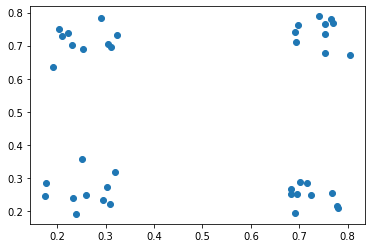

In [41]:
data = make_clusters([2,2], 10)
data.shape
plt.scatter(data[:,0], data[:,1]);

In [42]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(data)

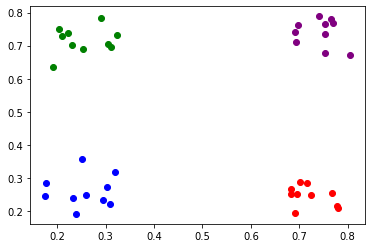

In [43]:
for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] == 0:
        plt.scatter(data[i,0], data[i,1], c='blue');
    elif kmeans.labels_[i] == 1:
        plt.scatter(data[i,0], data[i,1], c='green');
    elif kmeans.labels_[i] == 2:
        plt.scatter(data[i,0], data[i,1], c='red');
    else:
        plt.scatter(data[i,0], data[i,1], c='purple');
plt.show();

In [44]:
y = np.reshape(kmeans.labels_, (-1, 1))
data = np.append(data,y, axis=1)

In [45]:
fsp = Fair_Split_Tree(data, k=4)
tree = fsp.build_tree()

In [79]:
wspd =  WSPD(tree, 8)

In [80]:
wspd_pairs = wspd.compute_wspd()

In [81]:
len(wspd_pairs)

12

In [82]:
wspd.filter_pairs()

[(Node 15: [[0.75214319 0.67912544 3.        ]
   [0.75383144 0.73463462 3.        ]
   [0.80407356 0.67213195 3.        ]
   [0.69339724 0.70985602 3.        ]
   [0.77000077 0.769288   3.        ]
   [0.69659051 0.76347984 3.        ]
   [0.69130296 0.74210564 3.        ]
   [0.7660866  0.77896935 3.        ]
   [0.74012042 0.78871736 3.        ]
   [0.75257034 0.76391827 3.        ]],
  Node 16: [[0.77886827 0.21687823 2.        ]
   [0.69596258 0.25336428 2.        ]
   [0.68298466 0.25134701 2.        ]
   [0.69138086 0.1939956  2.        ]
   [0.6826985  0.26597355 2.        ]
   [0.71634371 0.28392134 2.        ]
   [0.70220954 0.28814901 2.        ]
   [0.77925114 0.20937559 2.        ]
   [0.76672496 0.2549327  2.        ]
   [0.72464739 0.24799212 2.        ]]),
 (Node 4: [[0.21050594 0.72981987 1.        ]
   [0.28959574 0.78225331 1.        ]
   [0.32468622 0.73299105 1.        ]
   [0.22328057 0.73703233 1.        ]
   [0.19166242 0.63682072 1.        ]
   [0.20481469 0.75

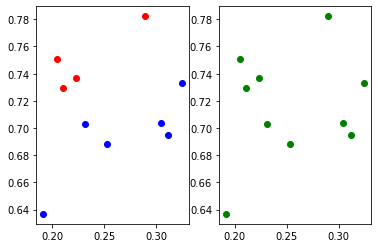

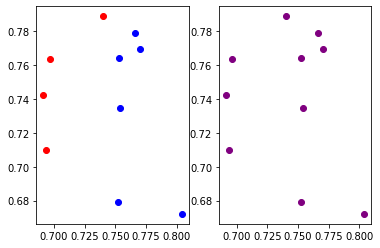

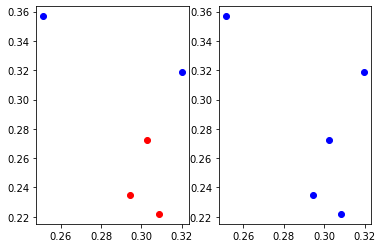

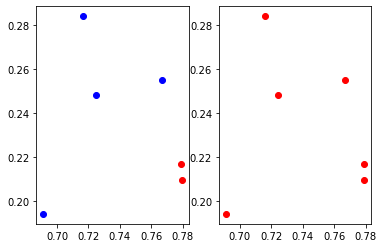

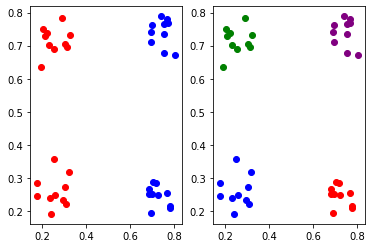

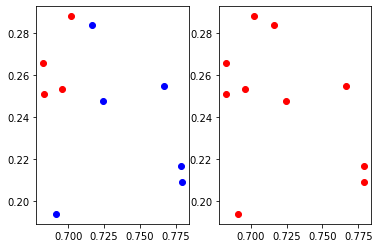

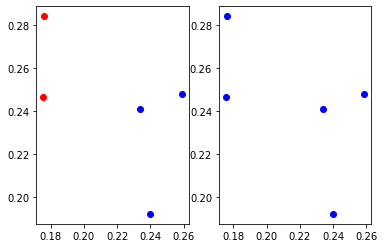

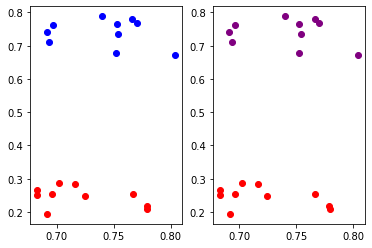

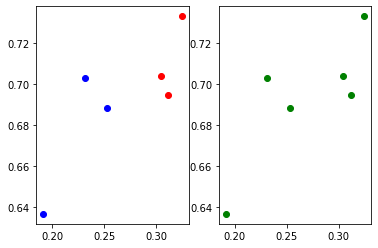

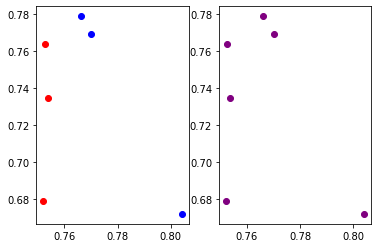

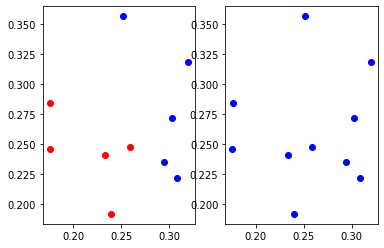

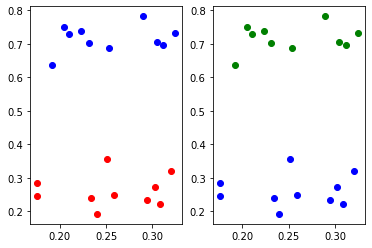

In [83]:
for i in range(len(wspd_pairs)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.scatter(wspd_pairs[i][0].dataset[:,0], wspd_pairs[i][0].dataset[:,1], c='blue');
    ax1.scatter(wspd_pairs[i][1].dataset[:,0], wspd_pairs[i][1].dataset[:,1], c='red');
    for j in range(wspd_pairs[i][0].dataset.shape[0]):
        if wspd_pairs[i][0].dataset[j,-1] == 0:
            ax2.scatter(wspd_pairs[i][0].dataset[j,0], wspd_pairs[i][0].dataset[j,1], c='blue');
        elif wspd_pairs[i][0].dataset[j,-1] == 1:
            ax2.scatter(wspd_pairs[i][0].dataset[j,0], wspd_pairs[i][0].dataset[j,1], c='green');
        elif wspd_pairs[i][0].dataset[j,-1] == 2:
            ax2.scatter(wspd_pairs[i][0].dataset[j,0], wspd_pairs[i][0].dataset[j,1], c='red');
        else:
            ax2.scatter(wspd_pairs[i][0].dataset[j,0], wspd_pairs[i][0].dataset[j,1], c='purple');
    for k in range(wspd_pairs[i][1].dataset.shape[0]):
        if wspd_pairs[i][1].dataset[k,-1] == 0:
            ax2.scatter(wspd_pairs[i][1].dataset[k,0], wspd_pairs[i][1].dataset[k,1], c='blue');
        elif wspd_pairs[i][1].dataset[k,-1] == 1:
            ax2.scatter(wspd_pairs[i][1].dataset[k,0], wspd_pairs[i][1].dataset[k,1], c='green');
        elif wspd_pairs[i][1].dataset[k,-1] == 2:
            ax2.scatter(wspd_pairs[i][1].dataset[k,0], wspd_pairs[i][1].dataset[k,1], c='red');
        else:
            ax2.scatter(wspd_pairs[i][1].dataset[k,0], wspd_pairs[i][1].dataset[k,1], c='purple');
    
    plt.show()

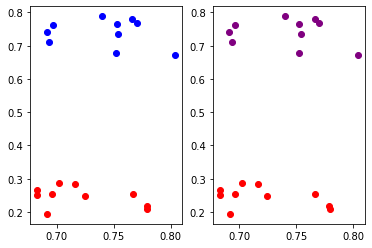

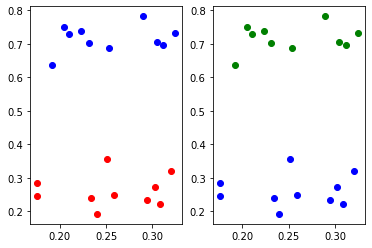

In [84]:
for i in range(len(new_wspd)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.scatter(new_wspd[i][0].dataset[:,0], new_wspd[i][0].dataset[:,1], c='blue');
    ax1.scatter(new_wspd[i][1].dataset[:,0], new_wspd[i][1].dataset[:,1], c='red');
    for j in range(new_wspd[i][0].dataset.shape[0]):
        if new_wspd[i][0].dataset[j,-1] == 0:
            ax2.scatter(new_wspd[i][0].dataset[j,0], new_wspd[i][0].dataset[j,1], c='blue');
        elif new_wspd[i][0].dataset[j,-1] == 1:
            ax2.scatter(new_wspd[i][0].dataset[j,0], new_wspd[i][0].dataset[j,1], c='green');
        elif new_wspd[i][0].dataset[j,-1] == 2:
            ax2.scatter(new_wspd[i][0].dataset[j,0], new_wspd[i][0].dataset[j,1], c='red');
        else:
            ax2.scatter(new_wspd[i][0].dataset[j,0], new_wspd[i][0].dataset[j,1], c='purple');
    for k in range(new_wspd[i][1].dataset.shape[0]):
        if new_wspd[i][1].dataset[k,-1] == 0:
            ax2.scatter(new_wspd[i][1].dataset[k,0], new_wspd[i][1].dataset[k,1], c='blue');
        elif new_wspd[i][1].dataset[k,-1] == 1:
            ax2.scatter(new_wspd[i][1].dataset[k,0], new_wspd[i][1].dataset[k,1], c='green');
        elif new_wspd[i][1].dataset[k,-1] == 2:
            ax2.scatter(new_wspd[i][1].dataset[k,0], new_wspd[i][1].dataset[k,1], c='red');
        else:
            ax2.scatter(new_wspd[i][1].dataset[k,0], new_wspd[i][1].dataset[k,1], c='purple');
    
    plt.show()

In [85]:
import math

In [86]:
e = math.ceil(math.log((1/8), 10) + 1)

In [87]:
e

1

In [90]:
new_wspd[0][0].dataset

array([[0.75214319, 0.67912544, 3.        ],
       [0.75383144, 0.73463462, 3.        ],
       [0.80407356, 0.67213195, 3.        ],
       [0.69339724, 0.70985602, 3.        ],
       [0.77000077, 0.769288  , 3.        ],
       [0.69659051, 0.76347984, 3.        ],
       [0.69130296, 0.74210564, 3.        ],
       [0.7660866 , 0.77896935, 3.        ],
       [0.74012042, 0.78871736, 3.        ],
       [0.75257034, 0.76391827, 3.        ]])

In [92]:
def find_center(points):
    return np.sum(points, axis=0)/points.shape[0]

In [ ]:
for pair in new_wspd:
    for i in range(-2,e+1):
        

0.12350771175545192
0.24701542351090383
0.49403084702180766
0.9880616940436153


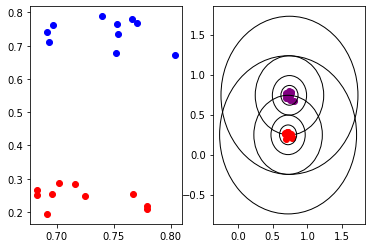

0.11358538014847736
0.2271707602969547
0.4543415205939094
0.9086830411878188


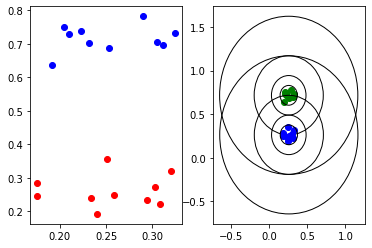

In [97]:
for i in range(len(new_wspd)):
    center_u = find_center(new_wspd[i][0].dataset[:, :-1])
    center_v = find_center(new_wspd[i][1].dataset[:, :-1])
    l = np.linalg.norm(center_u- center_v)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.scatter(new_wspd[i][0].dataset[:,0], new_wspd[i][0].dataset[:,1], c='blue');
    ax1.scatter(new_wspd[i][1].dataset[:,0], new_wspd[i][1].dataset[:,1], c='red');
    for j in range(new_wspd[i][0].dataset.shape[0]):
        if new_wspd[i][0].dataset[j,-1] == 0:
            ax2.scatter(new_wspd[i][0].dataset[j,0], new_wspd[i][0].dataset[j,1], c='blue');
        elif new_wspd[i][0].dataset[j,-1] == 1:
            ax2.scatter(new_wspd[i][0].dataset[j,0], new_wspd[i][0].dataset[j,1], c='green');
        elif new_wspd[i][0].dataset[j,-1] == 2:
            ax2.scatter(new_wspd[i][0].dataset[j,0], new_wspd[i][0].dataset[j,1], c='red');
        else:
            ax2.scatter(new_wspd[i][0].dataset[j,0], new_wspd[i][0].dataset[j,1], c='purple');
    for m in range(-2,e+1):
        print(pow(2, m)*l)
        circle1 = plt.Circle( (center_u[0], center_u[1] ), pow(2, m)*l, fill = False );
        ax2.add_patch(circle1)
    for k in range(new_wspd[i][1].dataset.shape[0]):
        if new_wspd[i][1].dataset[k,-1] == 0:
            ax2.scatter(new_wspd[i][1].dataset[k,0], new_wspd[i][1].dataset[k,1], c='blue');
        elif new_wspd[i][1].dataset[k,-1] == 1:
            ax2.scatter(new_wspd[i][1].dataset[k,0], new_wspd[i][1].dataset[k,1], c='green');
        elif new_wspd[i][1].dataset[k,-1] == 2:
            ax2.scatter(new_wspd[i][1].dataset[k,0], new_wspd[i][1].dataset[k,1], c='red');
        else:
            ax2.scatter(new_wspd[i][1].dataset[k,0], new_wspd[i][1].dataset[k,1], c='purple');
    for m in range(-2,e+1):
        circle1 = plt.Circle( (center_v[0], center_v[1] ), pow(2, m)*l, fill = False );
        ax2.add_patch(circle1)
    plt.show()